In [29]:
import json
import os.path as op
import os
import torch 
import tqdm
import pandas as pd
import scipy.stats as st
from scipy.spatial import distance
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch_geometric.data import DataLoader, Data
import h5py
from ase.md.nvtberendsen import NVTBerendsen
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase import units
from ase.io.trajectory import Trajectory
import ase
import argparse

# custom functions
from utils.data import test_dataloader, dataloader
from utils.models import load_model
from utils.infer import infer, infer_with_error
from utils.model_to_ase import SchnetCalculator
#from ttm.ase import SciPyFminLBFGSB, TTMCalculator

from utils.water_dataset import PrepackedDataset


def roundto(x, base=5):
    return base * round(x/base)

In [15]:
basedir = '/people/herm379/exalearn/IPU_trained_models/fast-finedtuned-forcefields/'
modeldir = 'finetune_results/knn_no_mean_std_take4'

In [17]:
with open(op.join(basedir, modeldir, 'args.json')) as f:
    args_dict = json.load(f)
    args = argparse.Namespace(**args_dict)
    
args

Namespace(create_splits=True, splitdir='./data/splits/', datadir='./data/cached_dataset/', energy_coeff=0.05, mae_std_from_val=True, max_to_add=1, n_epochs_initial=50, n_epochs_al=10, n_epochs_end=50, n_al_iters=50, save_models=True, start_lr=0.001, datasets='mctbp_1000', n_train=[5000], n_to_examine=[5000], mean='None', std='None', start_model='./pretrained_models/2-7milweights', neighbor_method='knn', load_state=True, clip_value=200.0, batch_size=128)

In [55]:
import sys
sys.path.insert(0, '/people/herm379/exalearn/IPU_trained_models/pnnl_sandbox/schnet')
from model import SchNet

# get final model
finalmodel=[x for x in os.listdir(op.join(basedir, modeldir)) if x.endswith('final.pt')][0]
    
# load state dict of trained model
state=torch.load(op.join(basedir, modeldir, finalmodel))
# remove module. from statedict keys (artifact of parallel gpu training)
state = {k.replace('module.',''):v for k,v in state.items()}

# extract model params from model state dict
num_gaussians = state['basis_expansion.offset'].shape[0]
num_filters = state['interactions.0.mlp.0.weight'].shape[0]
num_interactions = len([key for key in state.keys() if '.lin.bias' in key])

# load model architecture
net = SchNet(num_features = num_filters,
             num_interactions = num_interactions,
             num_gaussians = num_gaussians,
             cutoff = 6.0)   

# load trained weights into model
net.load_state_dict(state)
print(f'model weights loaded from {op.join(basedir, modeldir, finalmodel)}')

model weights loaded from /people/herm379/exalearn/IPU_trained_models/fast-finedtuned-forcefields/finetune_results/knn_no_mean_std_take4/finetune_ttm_final.pt


In [27]:
dataset=op.join(basedir, args.datadir, args.datasets+'_data.hdf5')
split=op.join(basedir, args.splitdir, 'split_00_'+args.datasets+'.npz')

In [31]:
dataset = PrepackedDataset(None, 
                           split, 
                           args.datasets, 
                           directory=op.join(basedir, args.datadir))


test_data=dataset.load_data('test')
len(test_data)

In [33]:
loader = DataLoader(test_data, batch_size=128, shuffle=False)

In [60]:
from datetime import datetime
from utils.infer import force_magnitude_error, force_angular_error

fme_all = np.array(())
fae_all = np.array(())

df = pd.DataFrame()
print(datetime.now().isoformat(timespec='seconds'))
for data in loader:
    # get predicted values
    data.pos.requires_grad=True
    e = net(data)
    
    f = torch.autograd.grad(e, data.pos, grad_outputs=torch.ones_like(e), retain_graph=False)[0]
    
    # force errors 
    fme  = force_magnitude_error(data.f, f).numpy()
    fae  = force_angular_error(data.f, f).numpy()
    
    fme_all = np.concatenate((fme_all, fme))
    fme_all = np.concatenate((fae_all, fae))
    
    # get means of individual samples
    start = 0
    fme_individual = []
    fae_individual = []
    for size in data.size.numpy()*3:
        fme_individual.append(np.mean(np.abs(fme[start:start+size])))
        fae_individual.append(np.mean(np.abs(fae[start:start+size])))
        start += size
    
    tmp = pd.DataFrame({'size': size, 'e_actual': data.y.numpy(), 'e_pred': e.detach().numpy(),
                        'fme_mae':fme_individual, 'fae_mae':fae_individual})
    df = pd.concat([df, tmp])

print(datetime.now().isoformat(timespec='seconds'))
# all data together 
print(np.mean(np.abs(fme)))
print(np.mean(np.abs(fae)))   

df.head()

2022-10-11T12:11:47
2022-10-11T12:48:28
14.349704
0.49629974


,size,e_actual,e_pred,fme_mse,fae_mse
0,51,-27.144539,-27.248909,14.114537,0.527713
1,51,-100.147491,-99.706276,10.984165,0.451937
2,51,-111.174843,-111.014404,13.253590,0.530813
3,51,-196.418289,-197.363831,11.854053,0.487858
4,51,-143.303055,-142.600525,15.832561,0.546724


In [62]:
import seaborn as sns
import matplotlib.pyplot as plt


def myround(x, base=5):
    return base * round(x/base)

df['e_diff']=df['e_actual']-df['e_pred']
df['e_mae']=df['e_diff'].apply(lambda x: np.mean(np.abs(x)))
df['e_actual_round'] = df['e_actual'].apply(lambda x: myround(x))

df['e_water'] = df['e_actual']/df['size']
df['e_water_round'] = df['e_water'].apply(lambda x: myround(x, 2))
df.head()

,size,e_actual,e_pred,fme_mse,fae_mse,e_diff,e_mae,e_actual_round,e_water,e_water_round
0,51,-27.144539,-27.248909,14.114537,0.527713,0.104370,0.104370,-25,-0.532246,0
1,51,-100.147491,-99.706276,10.984165,0.451937,-0.441216,0.441216,-100,-1.963676,-2
2,51,-111.174843,-111.014404,13.253590,0.530813,-0.160439,0.160439,-110,-2.179899,-2
3,51,-196.418289,-197.363831,11.854053,0.487858,0.945541,0.945541,-195,-3.851339,-4
4,51,-143.303055,-142.600525,15.832561,0.546724,-0.702530,0.702530,-145,-2.809864,-2


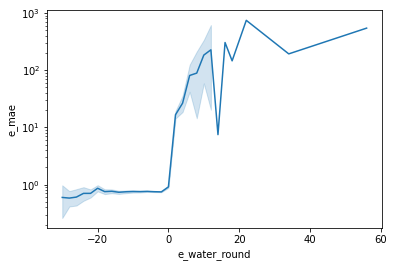

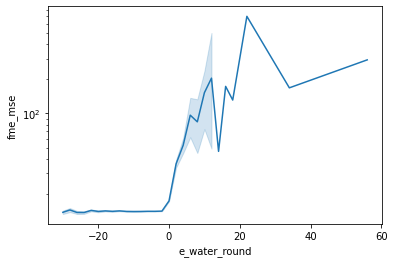

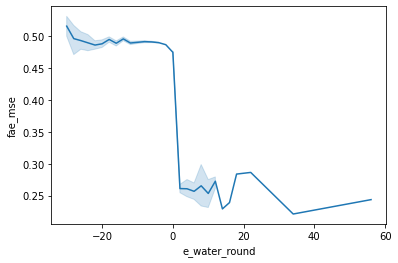

In [63]:
for y in ['e_mae','fme_mae', 'fae_mae']:
    sns.lineplot(data=df, x='e_water_round', y=y)
    if y !='fae_mae':
        plt.yscale('log')
    plt.show()